##  Experiment: using a Neural Network to fit a non-linear function: `sin(x)`

> Try to perfectly fit the data without knowing the function that generated it.

In [1]:
import os
os.mkdir('animation')
os.chdir('animation')
os.mkdir('imgs')
os.chdir('imgs')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [3]:
X = torch.arange(0, 10, step=0.005)

noise = torch.randn(len(X))

X += noise
X = X.unsqueeze(dim=1)

y = torch.sin(X)

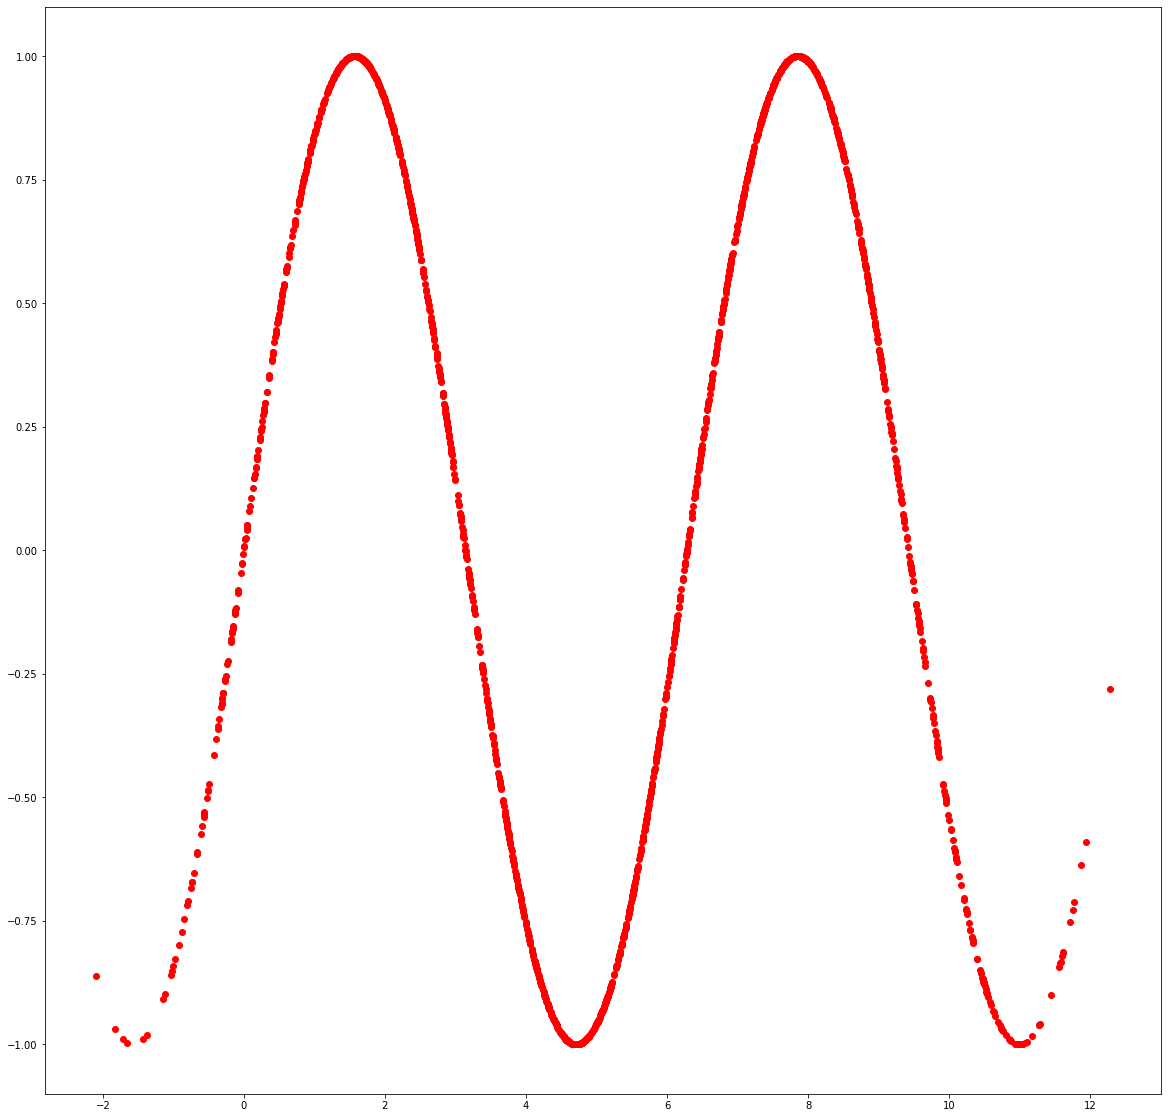

In [4]:
plt.figure(figsize=(20, 20))
plt.scatter(X, y, c='r')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

In [6]:
assert len(X_train) + len(X_test) == len(X)
assert len(y_train) + len(y_test) == len(y)

In [7]:
X_train.shape, y_train.shape

(torch.Size([1600, 1]), torch.Size([1600, 1]))

### Device-agnostic code

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Defining a model

In [9]:
torch.manual_seed(42)

In [10]:
class SineModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=1, out_features=100)
        self.layer_2 = nn.Linear(in_features=100, out_features=50)
        self.layer_3 = nn.Linear(in_features=50, out_features=20)
        self.layer_4 = nn.Linear(in_features=20, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

In [11]:
model = SineModel().to(device)
model

SineModel(
  (layer_1): Linear(in_features=1, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=50, bias=True)
  (layer_3): Linear(in_features=50, out_features=20, bias=True)
  (layer_4): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [12]:
# Loss and optimizer

# regression problem -> L1 loss
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr = 0.0005)

## Function to generate images of the plot

In [13]:
def plot_predictions(train_data, train_labels, test_data,
                    test_labels, i, predictions=None):
    
    plt.figure(figsize=(10, 7))
        
    plt.scatter(train_data, train_labels, c="blue", s=4, label="Train data")
    plt.scatter(test_data, test_labels, c="green", s=4, label="Train data")
    
    if predictions is not None:
        plt.scatter(test_data,predictions,c='red', s=4, label=f"Predictions\nEpoch: {i}")
    
    plt.legend(prop={"size": 15}, loc='upper right')
    plt.savefig(f"plot{i}.png", bbox_inches='tight')
    plt.clf()
    plt.close()

## Building a training/testing loop

In [14]:
EPOCHS = 500

# tracking results
epoch_count = []
loss_values = []
test_loss_values = []

### Training

for epoch in range(EPOCHS):
    model.train()
    
    y_pred = model(X_train)
    
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ### Testing
    model.eval()
    
    with torch.inference_mode():
        test_preds = model(X_test)
        test_loss = loss_fn(test_preds, y_test)
        
        all_dataset_preds = model(X_test)
        
    
    if epoch % 10 == 0:
        
        plot_predictions(train_data=X_train,
               train_labels=y_train,
               test_data=X_test,
               test_labels=y_test,
               predictions=all_dataset_preds.squeeze(), 
               i=epoch)
        
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch {epoch} | Loss {loss:.4f} | Test loss: {test_loss:.4f}")

Epoch 0 | Loss 0.6596 | Test loss: 0.6391
Epoch 10 | Loss 0.6380 | Test loss: 0.6110
Epoch 20 | Loss 0.6230 | Test loss: 0.5998
Epoch 30 | Loss 0.6061 | Test loss: 0.5825
Epoch 40 | Loss 0.5845 | Test loss: 0.5619
Epoch 50 | Loss 0.5597 | Test loss: 0.5384
Epoch 60 | Loss 0.5331 | Test loss: 0.5151
Epoch 70 | Loss 0.5075 | Test loss: 0.4896
Epoch 80 | Loss 0.4868 | Test loss: 0.4701
Epoch 90 | Loss 0.4653 | Test loss: 0.4492
Epoch 100 | Loss 0.4411 | Test loss: 0.4265
Epoch 110 | Loss 0.4141 | Test loss: 0.3995
Epoch 120 | Loss 0.3877 | Test loss: 0.3720
Epoch 130 | Loss 0.3597 | Test loss: 0.3459
Epoch 140 | Loss 0.3333 | Test loss: 0.3226
Epoch 150 | Loss 0.3204 | Test loss: 0.3061
Epoch 160 | Loss 0.2944 | Test loss: 0.2871
Epoch 170 | Loss 0.2770 | Test loss: 0.2761
Epoch 180 | Loss 0.2663 | Test loss: 0.2716
Epoch 190 | Loss 0.2601 | Test loss: 0.2603
Epoch 200 | Loss 0.2526 | Test loss: 0.2539
Epoch 210 | Loss 0.2399 | Test loss: 0.2458
Epoch 220 | Loss 0.2328 | Test loss: 0.2366

In [15]:
# converting from tensor format to numpy
loss_values = np.array(torch.tensor(loss_values).numpy())
test_loss_values = np.array(torch.tensor(test_loss_values).numpy())

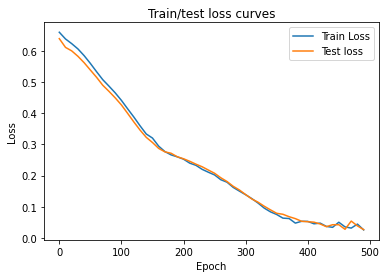

In [16]:
# Plotting the loss curves
plt.plot(epoch_count, loss_values, label='Train Loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title("Train/test loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Turning `.png` into a `gif`

In [17]:
### code adapted from: https://www.blog.pythonlibrary.org/2021/06/23/creating-an-animated-gif-with-python/

import glob

from PIL import Image

def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    os.chdir('..')
    frame_one.save("animation.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
    

make_gif('.')